In [35]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [36]:
import yfinance as yf

In [37]:
df = yf.download(tickers='AAPL', period='10y', interval='1d')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-31,18.233213,19.121429,18.178572,19.006071,16.344992,659492400
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.862825,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.649981,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.186193,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.090986,484156400
...,...,...,...,...,...,...
2022-12-22,134.350006,134.559998,130.300003,132.229996,132.229996,77852100
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.860001,63771000
2022-12-27,131.380005,131.410004,128.720001,130.029999,130.029999,69007800


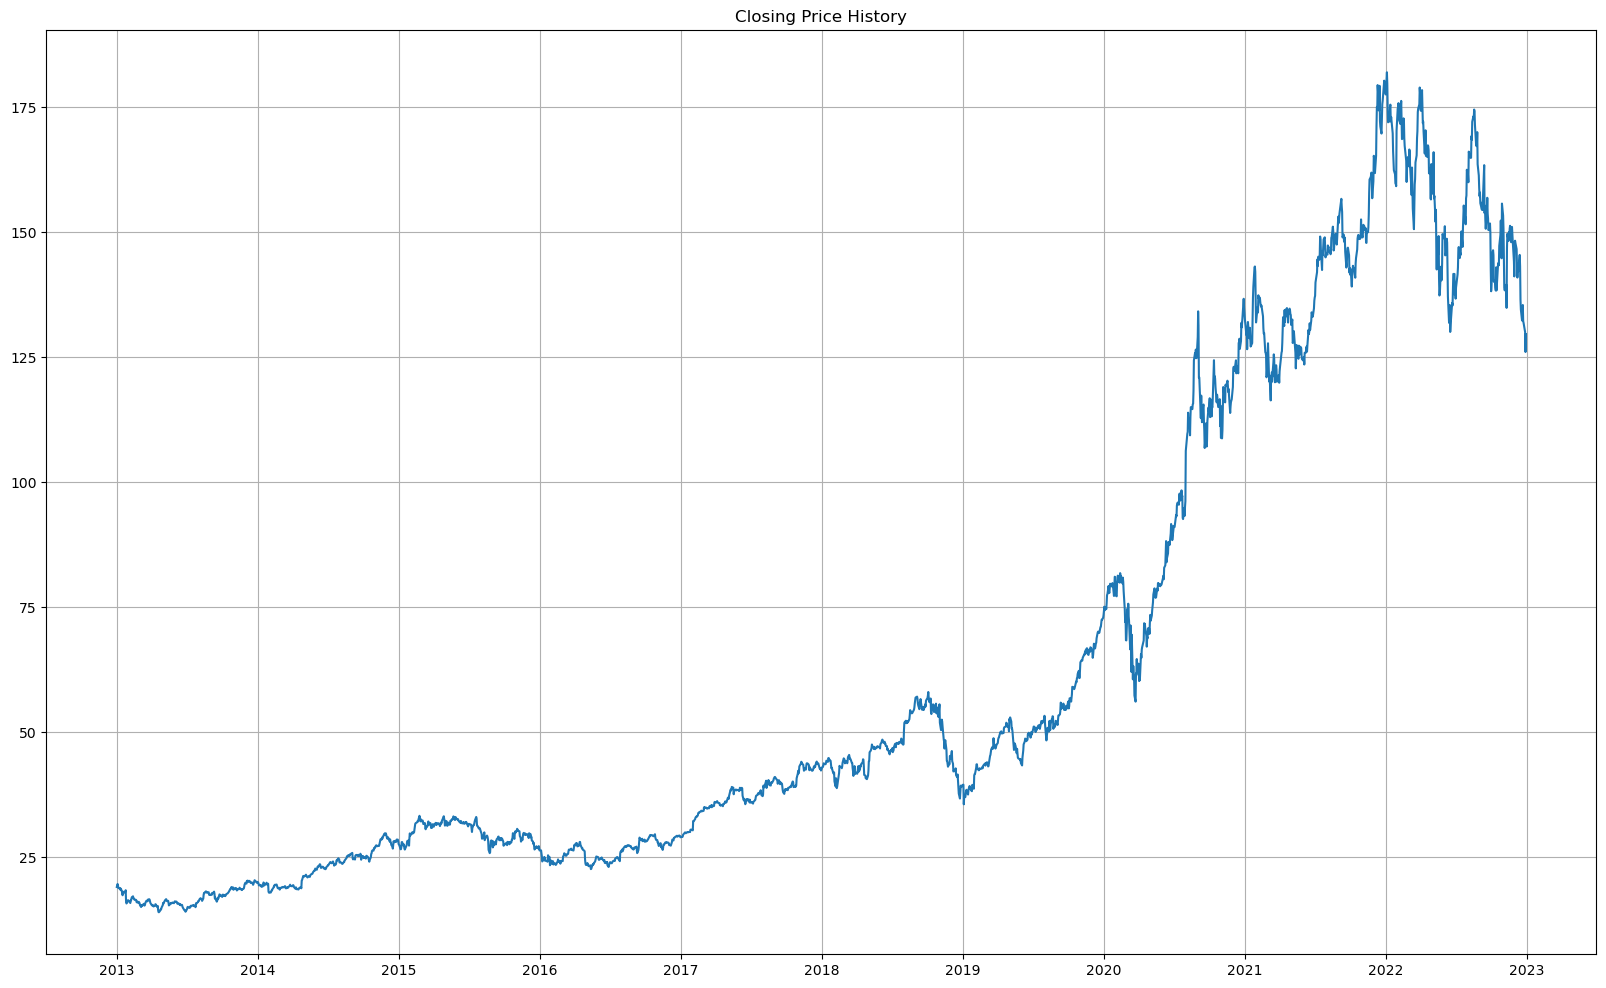

In [38]:
plt.figure(figsize=(20,12))
plt.grid()
plt.title('Closing Price History')
plt.plot(df['Close'])

In [39]:
data=df.filter(['Close'])

In [40]:
#converting data frame to numpy array
dataset=data.values

In [41]:
#number of rows to train our model on,lets say 80% of data set
training_data_len= math.ceil(len(dataset)*0.8)
training_data_len

2015

In [42]:
#Scaling input data for neural network
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data

array([[0.03009934],
       [0.03368219],
       [0.03220953],
       ...,
       [0.69071032],
       [0.66696916],
       [0.68821126]])

In [43]:
#creating scaled training dataset
train_data=scaled_data[0:training_data_len,:]
x_train=[]
y_train=[]
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
#So basically we are using the previous 60 values of closing price as input
#and the 61st value of closing price as output. So starting from the 61st
#closing price value, all closing price values are part of y_train


In [44]:
x_train=np.array(x_train)
y_train=np.array(y_train)
# the LSTM model requires 3 dimensional data as imput containing the following -number of samples,number of time steps, number of features
x_train=np.reshape(x_train,(x_train.shape[0],60,1))
x_train.shape

(1955, 60, 1)

In [45]:
model=Sequential()
#First and second layers are  LSTM layers having 50 neurons
model.add(LSTM(100, return_sequences=True, input_shape=(60,1)))
model.add(LSTM(100, return_sequences=False))
#third layer is a normal layer having 25 neurons
model.add(Dense(25))
#output layer
model.add(Dense(1))


In [46]:
model.compile(optimizer='adam',loss='mean_squared_error')
#Optimizer is used to improve upon loss fn

In [47]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

1955/1955 [==============================] - 38s 19ms/step - loss: 7.5582e-04


In [48]:
test_data=scaled_data[training_data_len-60:,:]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])


In [49]:
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [50]:
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

16/16 [==============================] - 1s 22ms/step


In [51]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions

/var/folders/60/ll343kb51r7cwjgwcfkhfstc0000gn/T/ipykernel_83611/3121654489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions


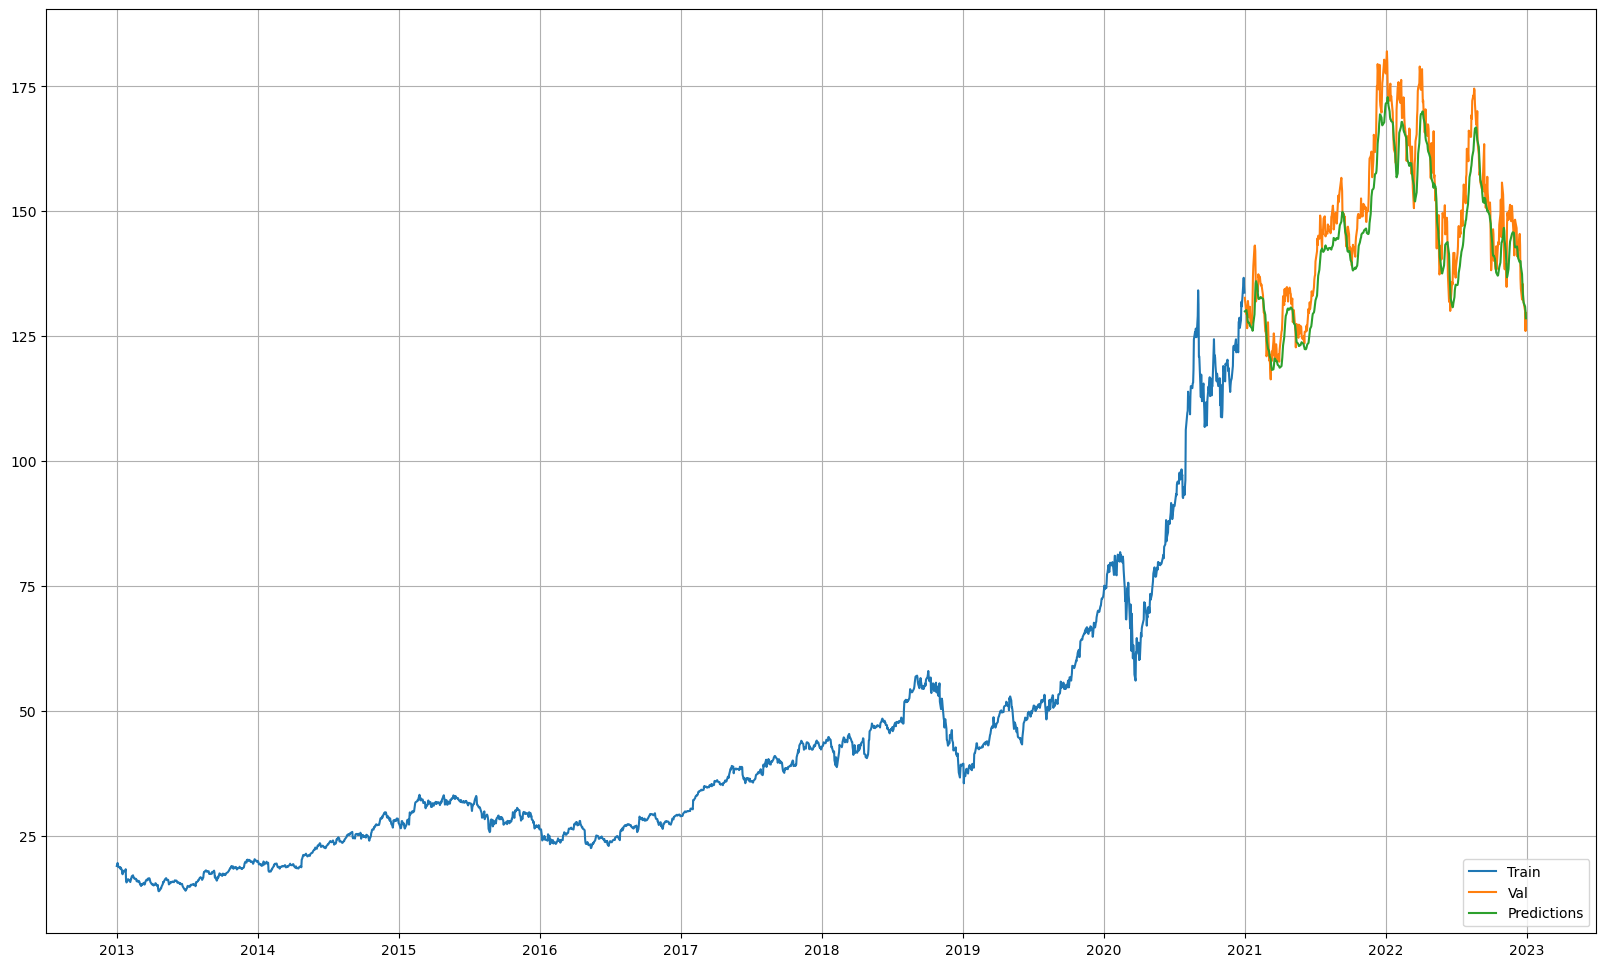

In [52]:
plt.figure(figsize=(20,12))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.grid()
plt.show()

In [53]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse
#ROOT_MEAN_SQUARED_ERROR:-

3.9995936399425713